In [ ]:
# Data Processing
import pandas as pd
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv("directory_to_the_csv_file", index_col=0)

In [ ]:
df.iloc[0:5,0:5]

,AAK1,AASS,AATK,ABAT,ABCA1
GSM338860,6.170397,5.606532,8.186989,7.100655,4.965535
GSM338861,6.112532,5.407005,8.530366,7.131207,4.912667
GSM338863,6.164055,5.518116,7.642412,7.221282,4.962869
GSM338865,6.423721,5.650853,8.372038,7.381892,4.956469
GSM338866,6.631895,5.701830,7.903833,7.641011,4.991327


### Split df to X and Class to y

In [ ]:
# Separate features and target
X = df.drop(columns = ['Class'])
y = df['Class']

## Feature Selection: Mutual Information

In [ ]:
from sklearn.feature_selection import mutual_info_classif, SelectKBest

In [ ]:
# Compute mutual information
mi = mutual_info_classif(X, y, random_state=42)

# Create a DataFrame for better visualization
mi_df = pd.DataFrame({'Feature': X.columns, 'Mutual Information': mi})
mi_df = mi_df.sort_values(by='Mutual Information', ascending=False)
print(mi_df)

       Feature  Mutual Information
801      FOXG1            0.509560
1185      KLK8            0.503506
857        GDA            0.435089
1801     PTPN5            0.434184
1829    RAB40B            0.398203
...        ...                 ...
895      GNAI2            0.000000
1741  PPP1R14C            0.000000
909      GPM6A            0.000000
937      GRIK1            0.000000
1114     ITSN1            0.000000

[2525 rows x 2 columns]


In [ ]:
# Select top k features based on mutual information
k = 500  # Choose the number of top features you want
selector = SelectKBest(mutual_info_classif, k=k)
X_selected = selector.fit_transform(X, y)

### 80/20 Rule

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [ ]:
X_train.shape

(289, 500)

### Baseline Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Step 1: Encode labels to integers
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# Step 2: Convert integer labels to categorical (one-hot encoded)
num_classes = len(np.unique(y_train_encoded))
y_train_categorical = to_categorical(y_train_encoded, num_classes=num_classes)
y_test_categorical = to_categorical(y_test_encoded, num_classes=num_classes)

# Print shapes to verify
print("Shape of y_train_categorical:", y_train_categorical.shape)
print("Shape of y_test_categorical:", y_test_categorical.shape)

Shape of y_train_categorical: (289, 3)
Shape of y_test_categorical: (73, 3)


In [ ]:
# Define model architecture

np.random.seed(42)
tf.random.set_seed(42)

model = Sequential([
    Dense(469, activation="selu", kernel_initializer="lecun_normal", input_shape=(X_train.shape[1],)),
    Dense(87, activation="selu", kernel_initializer="lecun_normal"),
    Dense(16, activation="selu", kernel_initializer="lecun_normal"),
    Dense(num_classes, activation='softmax')  # Output layer
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train_categorical,
                    epochs=500,
                    batch_size=32,
                    validation_split=0.2,
                    verbose=1)

Epoch 1/500
8/8 [==============================] - 3s 94ms/step - loss: 7.0043 - accuracy: 0.3117 - val_loss: 2.7726 - val_accuracy: 0.1724
Epoch 2/500
8/8 [==============================] - 0s 17ms/step - loss: 1.9375 - accuracy: 0.3766 - val_loss: 1.7536 - val_accuracy: 0.4655
Epoch 3/500
8/8 [==============================] - 0s 23ms/step - loss: 1.3129 - accuracy: 0.5108 - val_loss: 1.1631 - val_accuracy: 0.3621
Epoch 4/500
8/8 [==============================] - 0s 17ms/step - loss: 1.5199 - accuracy: 0.4545 - val_loss: 1.7389 - val_accuracy: 0.4655
Epoch 5/500
8/8 [==============================] - 0s 21ms/step - loss: 1.3708 - accuracy: 0.4459 - val_loss: 1.7244 - val_accuracy: 0.4655
Epoch 6/500
8/8 [==============================] - 0s 21ms/step - loss: 1.2125 - accuracy: 0.4372 - val_loss: 1.8547 - val_accuracy: 0.4655
Epoch 7/500
8/8 [==============================] - 0s 19ms/step - loss: 1.5111 - accuracy: 0.5714 - val_loss: 1.4129 - val_accuracy: 0.4655
Epoch 8/500
8/8 [===

## Overfitting test

In [ ]:
from sklearn.metrics import accuracy_score

# Calculate training accuracy
y_train_pred_probs = model.predict(X_train)
y_train_pred = np.argmax(y_train_pred_probs, axis=1)
y_train_true = np.argmax(y_train_categorical, axis=1)
train_accuracy = accuracy_score(y_train_true, y_train_pred)
print("Training Accuracy:", train_accuracy)

# Calculate test accuracy
y_test_pred_probs = model.predict(X_test)
y_test_pred = np.argmax(y_test_pred_probs, axis=1)
y_test_true = np.argmax(y_test_categorical, axis=1)
test_accuracy = accuracy_score(y_test_true, y_test_pred)
print("Test Accuracy:", test_accuracy)

10/10 [==============================] - 0s 4ms/step
Training Accuracy: 0.9550173010380623
3/3 [==============================] - 0s 7ms/step
Test Accuracy: 0.863013698630137



### Feature Importance by MaxWeight
> Add blockquote



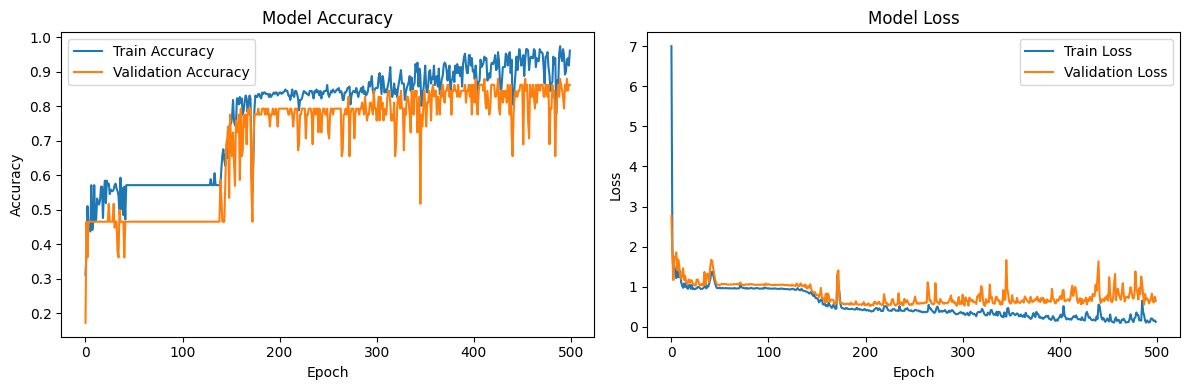

In [ ]:
# Optional: Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

MaxWeight Ranking:
1. feature_118: 0.3144
2. feature_9: 0.3088
3. feature_57: 0.3059
4. feature_198: 0.3043
5. feature_126: 0.3031
6. feature_173: 0.2937
7. feature_82: 0.2804
8. feature_117: 0.2745
9. feature_109: 0.2683
10. feature_183: 0.2648
11. feature_3: 0.2600
12. feature_6: 0.2581
13. feature_15: 0.2572
14. feature_106: 0.2565
15. feature_60: 0.2552
16. feature_151: 0.2532
17. feature_73: 0.2520
18. feature_172: 0.2509
19. feature_144: 0.2504
20. feature_164: 0.2495
21. feature_125: 0.2481
22. feature_160: 0.2464
23. feature_24: 0.2451
24. feature_88: 0.2442
25. feature_166: 0.2420
26. feature_84: 0.2419
27. feature_81: 0.2389
28. feature_21: 0.2379
29. feature_45: 0.2375
30. feature_92: 0.2339
31. feature_68: 0.2318
32. feature_136: 0.2318
33. feature_56: 0.2289
34. feature_194: 0.2263
35. feature_158: 0.2263
36. feature_48: 0.2257
37. feature_157: 0.2254
38. feature_123: 0.2253
39. feature_63: 0.2239
40. feature_100: 0.2230
41. feature_114: 0.2225
42. feature_189: 0.2222
43. 

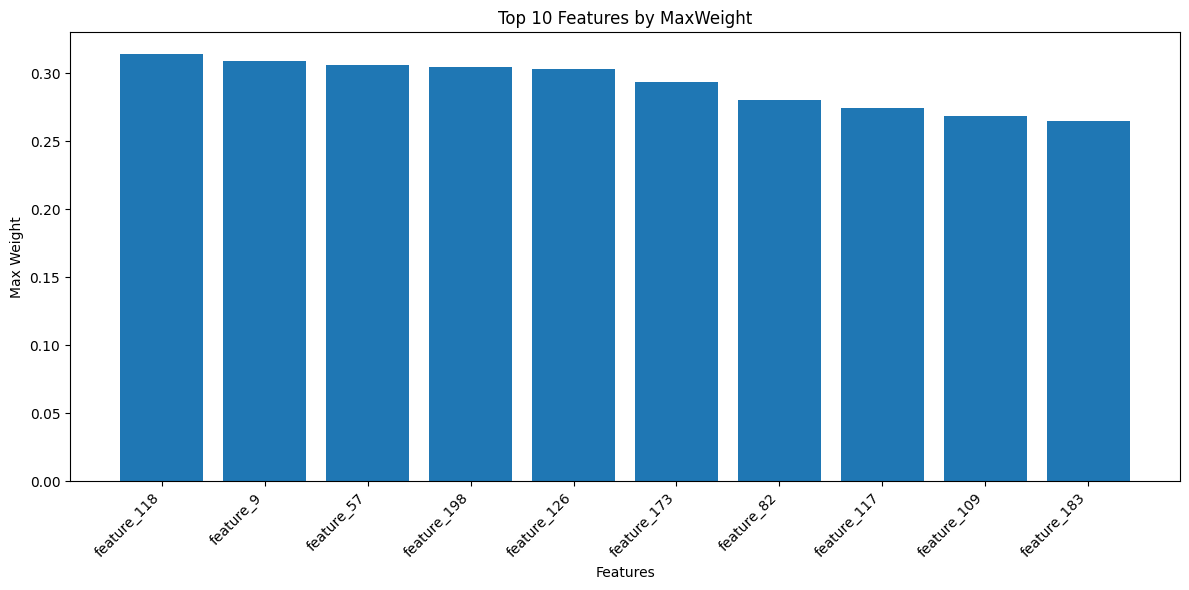

Verifying top features:
1. feature_118 (weight: 0.3144) corresponds to column: APOE
2. feature_9 (weight: 0.3088) corresponds to column: ABCG4
3. feature_57 (weight: 0.3059) corresponds to column: AFP
4. feature_198 (weight: 0.3043) corresponds to column: BAMBI
5. feature_126 (weight: 0.3031) corresponds to column: ARFGAP3
6. feature_173 (weight: 0.2937) corresponds to column: ATP6V1B2
7. feature_82 (weight: 0.2804) corresponds to column: ALOX5AP
8. feature_117 (weight: 0.2745) corresponds to column: APOD
9. feature_109 (weight: 0.2683) corresponds to column: APBB1
10. feature_183 (weight: 0.2648) corresponds to column: AXL

First few rows of top features:
                APOE     ABCG4       AFP     BAMBI   ARFGAP3
GSM338860  10.094439  6.635098  4.019913  4.894065  5.324773
GSM338861  10.453219  7.087537  3.892809  5.284372  5.597504
GSM338863  10.106630  7.197728  3.959605  5.519087  6.056144
GSM338865  10.323811  6.796778  3.765094  5.489061  5.229896
GSM338866  10.064056  6.703359

In [ ]:
def get_maxweight_ranking(model, feature_names):
    # Get the weights of the first layer
    first_layer_weights = model.layers[0].get_weights()[0]

    # Calculate the absolute values of weights
    abs_weights = np.abs(first_layer_weights)

    # Get the maximum weight for each input feature
    max_weights = np.max(abs_weights, axis=1)

    # Create a list of (feature, max_weight) tuples
    feature_weights = list(zip(feature_names, max_weights))

    # Sort the list by max_weight in descending order
    ranked_features = sorted(feature_weights, key=lambda x: x[1], reverse=True)

    return ranked_features

# Assuming your model is already defined and trained
# model = ...

# List of your feature names
feature_names = [f"feature_{i}" for i in range(X_train.shape[1])]  # Replace with your actual feature names

# Get the MaxWeight ranking
maxweight_ranking = get_maxweight_ranking(model, feature_names)

# Print the ranking
print("MaxWeight Ranking:")
for rank, (feature, weight) in enumerate(maxweight_ranking, 1):
    print(f"{rank}. {feature}: {weight:.4f}")

# Optionally, create a bar plot of the top N features
import matplotlib.pyplot as plt

def plot_top_features(ranking, top_n=10):
    top_features = ranking[:top_n]
    features, weights = zip(*top_features)

    plt.figure(figsize=(12, 6))
    plt.bar(features, weights)
    plt.title(f"Top {top_n} Features by MaxWeight")
    plt.xlabel("Features")
    plt.ylabel("Max Weight")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Plot top 10 features
plot_top_features(maxweight_ranking, top_n=10)

import pandas as pd

def verify_features(maxweight_ranking, df, top_n=10):
    print("Verifying top features:")
    for rank, (feature, weight) in enumerate(maxweight_ranking[:top_n], 1):
        feature_number = int(feature.split('_')[1])  # Extract number from 'feature_X'
        if feature_number < len(df.columns):
            original_column_name = df.columns[feature_number]
            print(f"{rank}. {feature} (weight: {weight:.4f}) corresponds to column: {original_column_name}")
        else:
            print(f"{rank}. {feature} (weight: {weight:.4f}) - No corresponding column found")

# Assuming maxweight_ranking is your result from the previous code
verify_features(maxweight_ranking, df)

# Optionally, display the first few rows of the top features
def display_top_features(maxweight_ranking, df, top_n=5):
    top_feature_numbers = [int(feature.split('_')[1]) for feature, _ in maxweight_ranking[:top_n]]
    top_columns = df.columns[top_feature_numbers]
    print("\nFirst few rows of top features:")
    print(df[top_columns].head())

display_top_features(maxweight_ranking, df)

### Confusion Matrix

In [ ]:
unique_labels = y.unique()
print(unique_labels)

['OPNA' 'TBI' 'EEV']


In [ ]:
# Define the class names based on the identified mapping
class_names = ['OPNA', 'TBI', 'EEV']

3/3 [==============================] - 0s 4ms/step


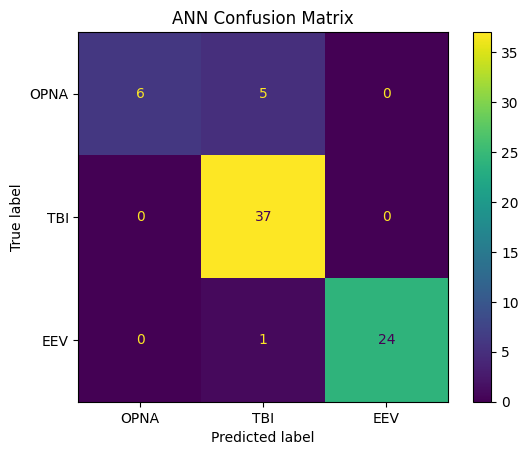

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Generate confusion matrix
# Get predictions
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

# Convert y_test_categorical back to class labels
y_test = np.argmax(y_test_categorical, axis=1)

# Create confusion matrix
cm_rf = confusion_matrix(y_test, y_pred)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=class_names)
disp_rf.plot(cmap=plt.cm.viridis)  # You can change the colormap if you prefer
plt.title("ANN Confusion Matrix")
plt.show()

### Top 100 Features

In [ ]:
# Select the top 100 features based on mutual information
top_100_features = mi_df['Feature'].head(100)
top_100_features_df = X[top_100_features]

for column in top_100_features_df.columns:
    print(column)

FOXG1
KLK8
GDA
PTPN5
RAB40B
KLRD1
LHX2
SFMBT2
KLF16
GCLM
IL12B
BCL11B
B3GNT5
OXNAD1
SHOX2
MAS1
MEIS1
FGL2
SLC25A23
DLX5
KCNE2
ABR
DPYSL4
ARX
TFPI2
DMP1
CD28
SOSTDC1
ICAM5
CHST1
SHF
MMP24
IFIT1
CD86
CST6
NETO1
HES5
SNX15
TTR
GRIN2C
SNCA
GIMAP4
ITPR1
PDE2A
DBN1
AKAP12
SDC1
PTK2B
ENC1
ACSL5
EPHA4
KCNA4
TBR1
HEBP1
EPHA6
CEBPD
RGS14
EN2
SAT1
BASP1
MYO5B
LMO7
PDE1A
DAB2IP
SOCS3
COMP
KL
CADPS2
FOSL2
FEZF2
ITGBL1
MICAL1
FOLR1
PFN2
PKP2
CX3CL1
ITPKA
MAL2
NEK6
KCTD4
NPY1R
MYC
RASL10A
LIG1
IL16
SOX4
PCDH8
TRPC4
INPP1
PRC1
PARD6A
CHRNA6
CHRNA5
CPE
VIP
KCNJ4
ILF3
MAB21L2
SELL
IL6
